In [ ]:
import gdown
gdown.download_folder('https://drive.google.com/drive/folders/1yAhxm2x0tpxjNzj66sP5xuD0IT5jIQPu',
                      output='../logs/report', quiet=True)

In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


sns.set_theme(
    context="paper",
    style="ticks",
    font_scale=1.0,
    rc={
        "figure.dpi": 300,
        "figure.constrained_layout.use": True,
        "lines.linewidth": 2,
        "figure.figsize": (4, 3), # (4x3 if 2-column, else 7x3.5)
    },
)

label_dict = {
    "lora": "LoRA",
    "vera": "VeRA",
    'dynalora': "DynaLoRA",
    "dinalora": "DinaLoRA"
}


def interpolate_to_same_length(array, length):
    """Saves the day when the array is not of the same length as the max length."""
    return np.interp(np.linspace(0, 1, length), np.linspace(0, 1, len(array)), array)


In [2]:
report_path = '../logs/report' if os.path.exists(
    '../logs/report') else '/content/report'  # colab mode
results_path = os.path.join(report_path, 'results.json')
pairings_path = os.path.join(report_path, 'pairings.json')
errors_path = os.path.join(report_path, 'errors.json')

with open(results_path) as f:
    results = json.load(f)
with open(pairings_path) as f:
    pairings = json.load(f)
with open(errors_path) as f:
    errors = json.load(f)

In [3]:
# initial cleaning of the data from unusable results.
# remove any experiment that does not have a measurements or an arguments field
todel = []
for job_id, job in results.items():
    for experiment_id, experiment in job.items():
        if ('No metrics' in errors[job_id][experiment_id]  # there is nothing to plot
                # likely no metrics then either
                or 'No log file' in errors[job_id][experiment_id]
                # likewise
            or 'could not read log file' in errors[job_id][experiment_id]
            or 'ModelArguments' not in experiment  # can't categorize
            ):
            todel.append((job_id, experiment_id))
            # print('removed experiment', experiment_id, 'from job', job_id)
            # print('reason:', errors[job_id][experiment_id])
            # print('corresponding pairing:')
            # print('  ', pairings[job_id][experiment_id].get('directory', 'no directory'))
            # print('  ', pairings[job_id][experiment_id].get('logfile', 'no logfile'))
for job_id, experiment_id in todel:
    del results[job_id][experiment_id]
    if len(results[job_id]) == 0:
        del results[job_id]
    del errors[job_id][experiment_id]
    if len(errors[job_id]) == 0:
        del errors[job_id]
print('removed', len(todel), 'experiments, from', len(
    set([job_id for job_id, _ in todel])), 'jobs')

removed 287 experiments, from 94 jobs


In [4]:
print("number of jobs:", len(results))
print("number of experiments:", sum([len(job) for job in results.values()]))

number of jobs: 75
number of experiments: 492


In [7]:
print('Number of results:', len(results))
print('Number of pairings:', len(pairings))
print('Number of errors:', len(errors))

error_messages = set([e for job_e in errors.values()
                     for experiment_e in job_e.values() for e in experiment_e])
print('Unique error messages:', len(error_messages))
print('  -', '\n  - '.join(error_messages))
print('_________________________')
unique_keys = set([k for job in results.values()
                  for experiment in job.values() for k in experiment.keys()])
print('Unique keys:', len(unique_keys))
print('  -', '\n  - '.join(unique_keys))
# take out the arguments key from each experiment
argument_dict = {}
for job_id, job in results.items():
    argument_dict[job_id] = {}
    for experiment_id, experiment in job.items():
        argument_dict[job_id][experiment_id] = experiment.get('ModelArguments')
        if 'ModelArgument' in experiment:
            del experiment['ModelArgument']
# it might be the case that ModelArguments is a key in the arguments dictionary
# we want to lift the elements of the ModelArguments dictionary to the top level
for job_id, job in argument_dict.items():
    for experiment_id, experiment in job.items():
        if 'ModelArguments' in experiment:
            experiment.update(experiment.pop('ModelArguments'))
print('_________________________')
unique_args = set([
    k for job in argument_dict.values()
    for experiment in job.values() for k in experiment.keys()])
print('Unique arguments:', len(unique_args))
print('  -', '\n  - '.join(unique_args))
# take measurements data from each experiment
measurements_dict = {}
for job_id, job in results.items():
    measurements_dict[job_id] = {}
    for experiment_id, experiment in job.items():
        measurements_dict[job_id][experiment_id] = experiment.get(
            'metrics', {})
unique_measuement_keys = set([
    k for job in measurements_dict.values()
    for experiment in job.values() for k in experiment.keys()])
print('_________________________')
print('Unique measurements:', len(unique_measuement_keys))
print('  -', '\n  - '.join(unique_measuement_keys))

Number of results: 75
Number of pairings: 149
Number of errors: 75
Unique error messages: 5
  - No reallocs
  - could not load dynalora_logs.json
  - No directory
  - could not load training_args.bin
  - No dynalora_logs.json
_________________________
Unique keys: 11
  - allocator
  - PeftConfig
  - metrics
  - adapter_base_names
  - ModelArguments
  - schedule
  - reallocs
  - num_params
  - aggregate
  - masks
  - cum_acts
_________________________
Unique arguments: 16
  - lora_r
  - model_name
  - target_modules
  - check_activations
  - lora_dropout
  - lora
  - vera_d_initial
  - allocator_type
  - epochs
  - aggregate_type
  - batch_size
  - lora_alpha
  - use_layerwise_optim
  - schedule_type
  - device
  - task
_________________________
Unique measurements: 6
  - epoch,grad_norm,learning_rate,loss
  - epoch,eval_loss,eval_matthews_correlation,eval_runtime,eval_samples_per_second,eval_steps_per_second
  - epoch,eval_loss,eval_pearson,eval_runtime,eval_samples_per_second,eval_spe

In [30]:
# build dataframes for the errors, arguments, and timeseries data
#  error header is job_id, experiment_id, error1, error2, ...

error_df = pd.DataFrame(data=[
    {'job_id': job_id, 'experiment_id': experiment_id,
        **{e: True for e in experiment_e}}
    for job_id, job_e in errors.items() for experiment_id, experiment_e in job_e.items()
], columns=['job_id', 'experiment_id'] + list(error_messages), dtype=bool)
error_df.fillna(value=False)
# fill the table row-by-row

# argument header is job_id, experiment_id, arg1, arg2, ...
flat_args = []
for job_id, job in argument_dict.items():
    for experiment, config in job.items():
        flat_args.append(
            {'job_id': job_id, 'experiment_id': experiment, **config})

# print(len(flat_args))
arg_df = pd.DataFrame(
    data=flat_args)
arg_df.fillna(value=np.nan, inplace=True)
# print the job id, experiment if and the experiment field if its not nan
# target_modules should default to ["query", "value"]
arg_df['target_modules'] = arg_df['target_modules'].apply(
    lambda x: x if x is not np.nan else ["query", "value"])
arg_df['allocator_type'] = arg_df['allocator_type'].apply(
    lambda x: x if x is not np.nan else "N/A")
arg_df['schedule_type'] = arg_df['schedule_type'].apply(
    lambda x: x if x is not np.nan else "N/A")

In [27]:
modes = ['train', 'eval', 'test', 'grad']
# for each mode, collect merics that have 'mode' as a prefix in at least one of their keys
#  we assume the reported dictionaries for each experiment is uniquely identified by the mode
modes_metrics = {}  # for
for job_id, job in results.items():
    for experiment_id, experiment in job.items():
        modes_metrics[(job_id, experiment_id)] = {mode: {} for mode in modes}
        for metric_key, metrics in experiment['metrics'].items():
            for mode in modes:
                # metric key is a concatenation of the contained dictionaries' keys
                if metric_key.find(mode) != -1:
                    if len(modes_metrics[(job_id, experiment_id)][mode]) == 0:
                        modes_metrics[(job_id, experiment_id)][mode] = {
                            m: [] for m in metrics[0].keys()}
                    for metric in metrics:
                        for m_name, m in metric.items():
                            modes_metrics[(job_id, experiment_id)
                                          ][mode][m_name].append(m)
                    break
            else:
                print('No mode found for key', metric_key)
                

# NOTE: CRITICAL
metrics = pd.DataFrame(modes_metrics).T


In [28]:
# EXTRACT DYNA METRICS
dyna_keys = [
    'adapter_base_names',
    'reallocs',
    'num_params',
    'masks',
    'cum_acts',  # NOTE: cum_acts may be a list or a dict. If its a dict, then it has two keys: acts and weights
    'acts',
    'weights'
]
if_dict_ca_keys = ['acts', 'weights']
dyna_dicts = {}
for job_id, job in results.items():
    for experiment_id, experiment in job.items():
        # if error_df.query(f'job_id == {job_id} && experiment_id == {experiment_id}')[['']]
        dyna_dicts[(job_id, experiment_id)] = {}
        for key in dyna_keys:
            if key in experiment:
                dyna_dicts[(job_id, experiment_id)][key] = experiment[key]
for key in dyna_dicts.keys():
    if ('cum_acts' in dyna_dicts[key] and
        len(dyna_dicts[key]['cum_acts']) > 0 and
            isinstance(dyna_dicts[key]['cum_acts'][0], dict)):
        acts, weights = [], []
        for act_wei in dyna_dicts[key]['cum_acts']:
            acts.append(act_wei['acts'])
            weights.append(act_wei['weights'])
        dyna_dicts[key].pop('cum_acts')
        dyna_dicts[key]['acts'] = acts
        dyna_dicts[key]['weights'] = weights

print(set([k for v in dyna_dicts.values() for k in v.keys()]))

{'adapter_base_names', 'acts', 'reallocs', 'weights', 'num_params', 'masks', 'cum_acts'}


In [31]:
# Store the indexing dataframe
args = arg_df.copy()
args['lora'] = args['lora'].fillna('dynalora')
args['task'] = args['task'].fillna('cola')
# args['model_name'] = args['model_name'].fillna('roberta-base')
args['use_layerwise_optim'] = args['use_layerwise_optim'].fillna(False)
# args = args.dropna(axis=1, how='any')
# args = args[args['lora'] != 'unknown']
# drop layerwise
args = args[~args['use_layerwise_optim']]

# clean-up
args['schedule_type'] = args['schedule_type'].str.replace(r'\\;', ';', regex=True)
args['allocator_type'] = args['allocator_type'].str.replace(r'\\;', ';', regex=True)
args['target_modules'] = args['target_modules'].apply(lambda x: (x,) if isinstance(x,str) else x).apply(sorted).apply(tuple)

args.to_csv('../logs/report/index_df.csv', index=False)
# args = pd.read_csv('../logs/report/index_df.csv')

## Loss computation 

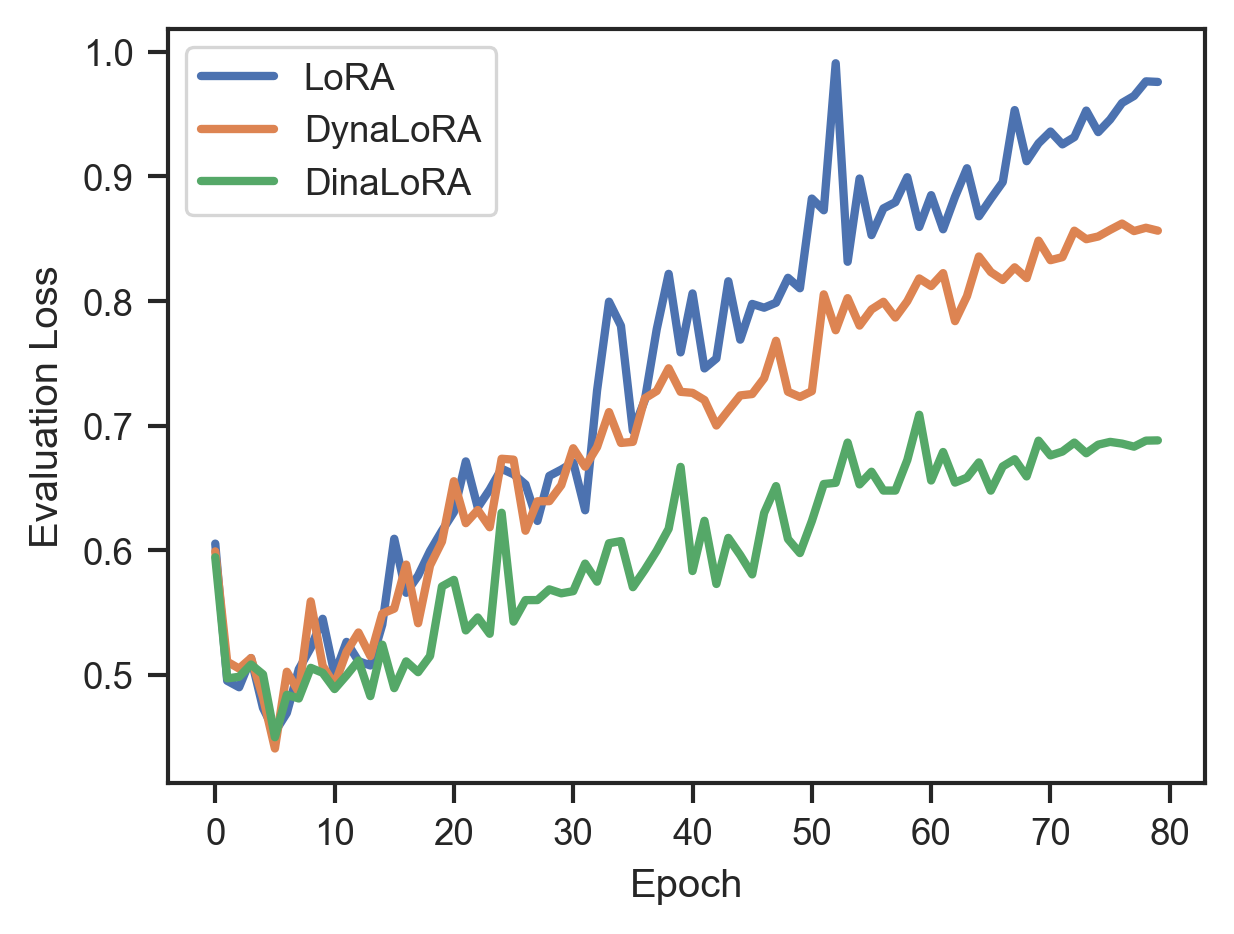

In [34]:
def get_mean_loss(lora_losses):
    max_length = max([len(row['eval']['eval_loss']) for idx, row in lora_losses.iterrows()])
    runs = []
    for row in lora_losses.itertuples():
        if row.train.get("epoch", [0])[0] < 20:
            continue
        
        runs.append(interpolate_to_same_length(row.eval['eval_loss'], max_length))
    return np.mean(runs, axis=0)

for lora in label_dict:
    index = args[(args['lora'] == lora) & (
        args['task'] == 'cola')][['job_id', 'experiment_id']]

    lora_losses = metrics.loc[index.values.tolist()]
    lora_losses = lora_losses.reset_index()
    
    if len(lora_losses) == 0:
        continue

    lora_mean = get_mean_loss(lora_losses)
    if isinstance(lora_mean, float):
        continue
    plt.plot(lora_mean, label=label_dict[lora])

plt.xlabel('Epoch')
plt.ylabel('Evaluation Loss')
plt.legend()

## Examine different schedules and allocator types.
We explore the effect of different schedules and allocator types for adapter module activation. We reuse the same model and training setup as before and vary each setting individually.

[('periodic;10', 0.6208847029318363, 0.008647606668309937),
 ('periodic;25', 0.6314267706887338, 0.015),
 ('periodic;30', 0.6032121451400153, 0.015),
 ('periodic;50', 0.6364402749047269, 0.0025669075324015944),
 ('periodic;70', 0.6081725386037139, 0.015),
 ('periodic;100', 0.6114826671159207, 0.004079241690856895),
 ('periodic;200', 0.6306906620617413, 0.015)]

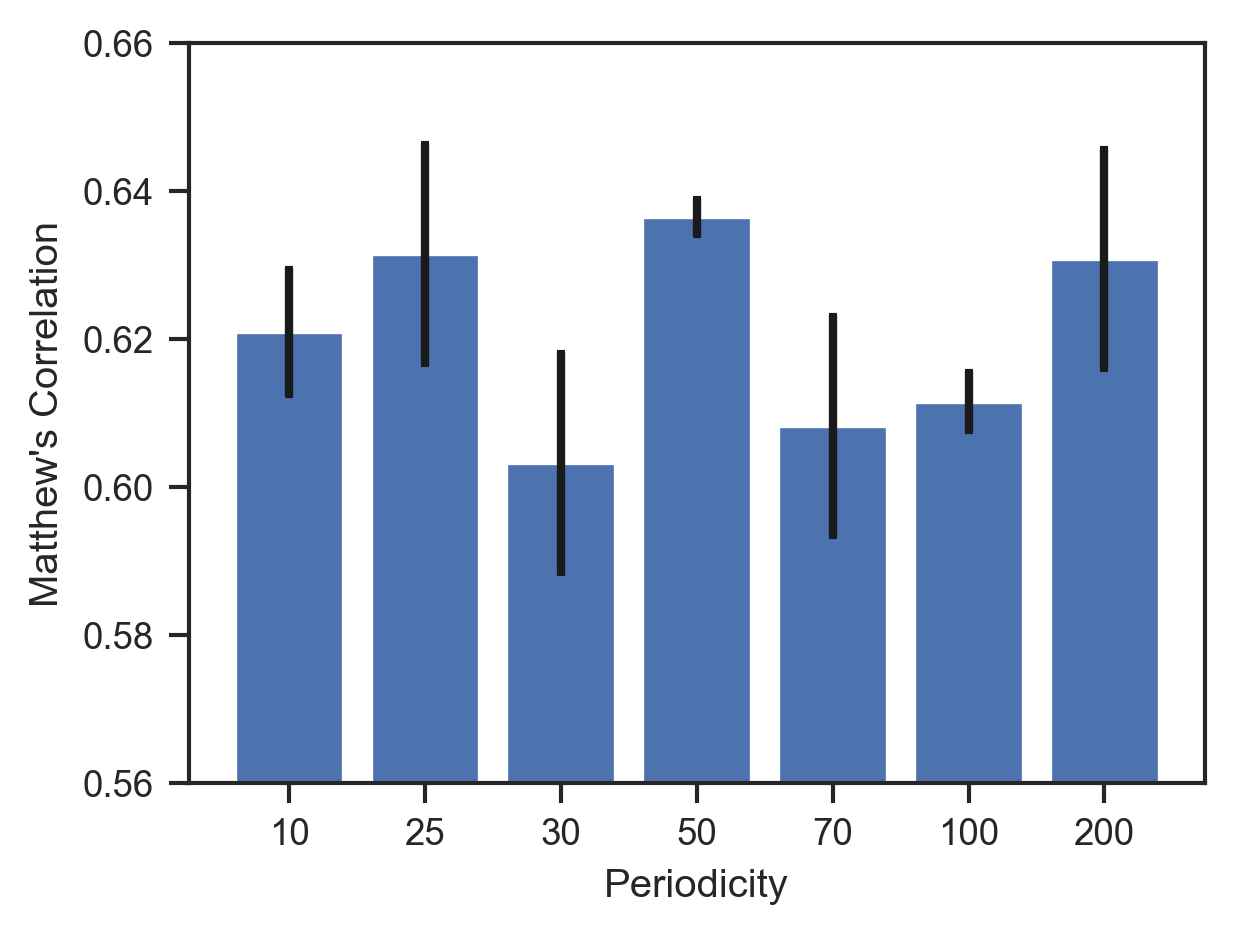

In [35]:
target_ablation = "schedule_type"  # schedule_type, allocator_type, target_modules
schedule_types = args[target_ablation].unique()
# schedule_types
gather = []

specific_index = (
    (args["target_modules"] == ("query", "value"))
) & (args["allocator_type"].str.contains(r"scaled_multinomial;1\d", regex=True))

indexer = args[(args["lora"] == "dynalora") & (args["task"] == "cola") & specific_index]
# Frozen indexing
# index =
for schedule_type in schedule_types:
    index = indexer[indexer[target_ablation] == schedule_type][
        ["job_id", "experiment_id"]
    ]
    samples = metrics.loc[index.values.astype(str).tolist()]
    samples = samples.reset_index()

    if len(samples) == 0:
        continue

    a = []
    for sample in samples.itertuples():
        if(sample.train.get('epoch', [0])[0] < 40): 
            continue
        a.append(max(sample.eval.get("eval_matthews_correlation", [0])))
    a = np.array(a)
    a = a[a > 0.2]
    if len(a) == 0:
        continue
    # print(f"schedule_type: {schedule_type}", "Mean:", np.mean(a))
    gather.append((schedule_type, np.mean(a), np.std(a)/2 or 0.015))

gather = sorted(gather, key=lambda x: x[0])
idx = min([i for i, (x, y, _) in enumerate(gather) if x.split(";")[0] == "periodic"])
gather = gather[:idx] + sorted(gather[idx:], key=lambda x: int(x[0].split(";")[-1]))

display(gather)
# Bar plot
plt.figure()
# container = plt.boxplot([y for x, y in gather])
container = plt.bar([x.split(';')[-1] for x, y,_ in gather], [y for x, y,_ in gather], yerr=[z for x, y, z in gather], capsize=1)
# container.patches[0].set_color("y")
# container.patches[1].set_color("g")
# plt.xticks(rotation=90)
plt.xlabel("Periodicity")
plt.ylabel("Matthew's Correlation")
# plt.title('Schedule Type vs Matthews Correlation')
plt.ylim(0.56, 0.66)
plt.show();

[('random;1', 0.472544582719824, 0.0),
 ('random;3', 0.4939866392816274, 0.0),
 ('scaled_multinomial;3', 0.4709975754506614, 0.0),
 ('random;4', 0.5145310557286741, 0.0),
 ('scaled_multinomial;4', 0.5242207694730159, 0.022220990514671038),
 ('random;5', 0.5049586645015167, 0.0),
 ('scaled_multinomial;5', 0.5259258925916567, 0.0),
 ('random;6', 0.5319354120310512, 0.0),
 ('random;7', 0.5546666671852067, 0.0),
 ('scaled_multinomial;7', 0.5738826222928127, 0.0),
 ('random;8', 0.6106988552195535, 0.0),
 ('scaled_multinomial;8', 0.5951569481479841, 0.00561421535979542),
 ('random;12', 0.6037743021259655, 0.0),
 ('scaled_multinomial;12', 0.6153296024308987, 0.013004317146536002),
 ('random;16', 0.5347185537666785, 0.0),
 ('scaled_multinomial;16', 0.6303466262807056, 0.011848142997161198),
 ('random;20', 0.6210462057873648, 0.0),
 ('scaled_multinomial;20', 0.637838463479626, 0.01048736812705479),
 ('random;24', 0.6481069022642968, 0.0),
 ('scaled_multinomial;24', 0.6442698819331673, 0.0086332

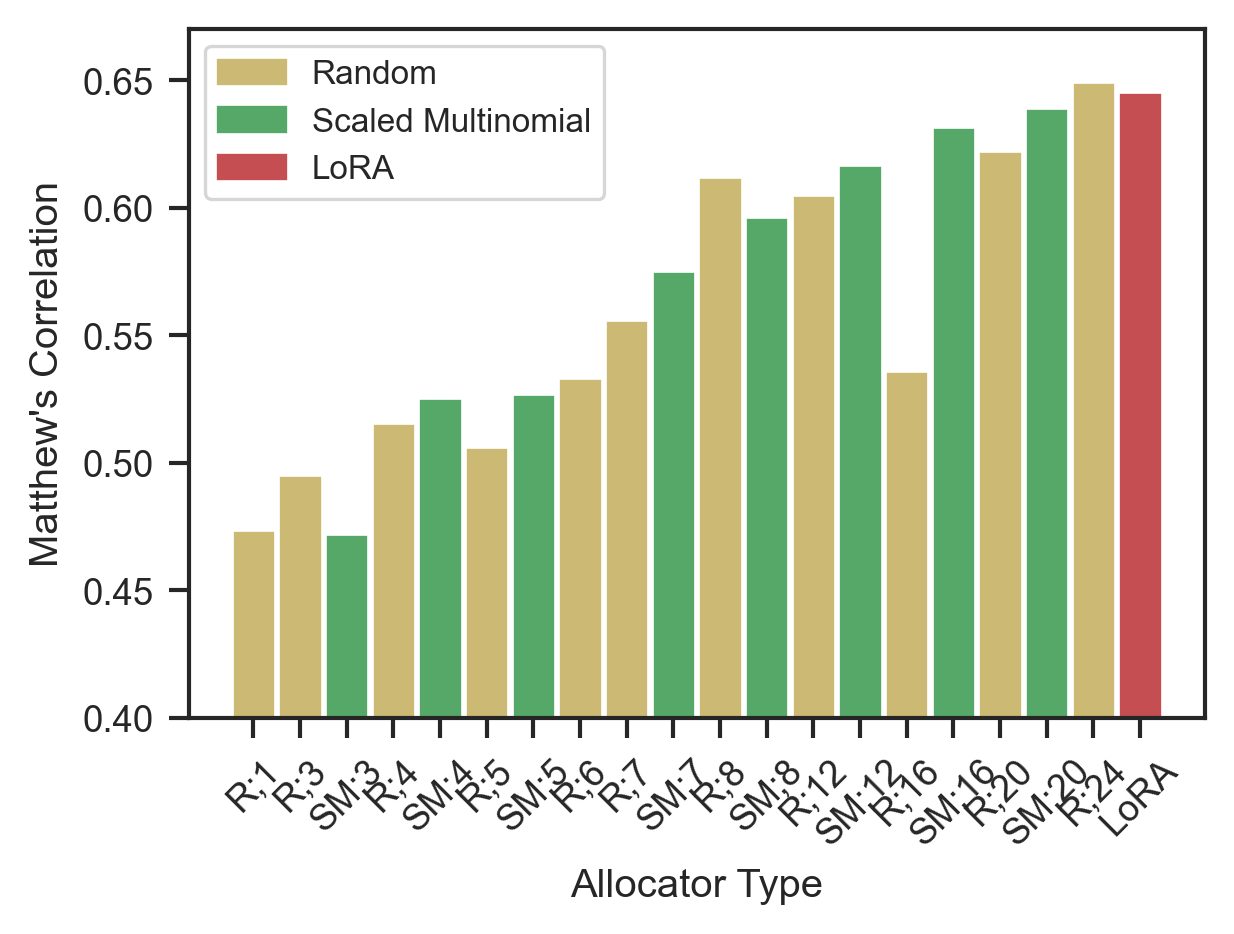

In [36]:
target_ablation = "allocator_type"  # schedule_type, allocator_type, target_modules
schedule_types = sorted(args[target_ablation].unique())
# schedule_types
gather = []

specific_index = (
    ((args["target_modules"] == ("query", "value"))) &
    args['schedule_type'].str.contains(r'periodic;\d', regex=True)
)
indexer = args[(args["lora"] == "dynalora") & (args["task"] == "cola") & specific_index]
# Frozen indexing
# index =
for schedule_type in schedule_types:
    index = indexer[indexer[target_ablation] == schedule_type][
        ["job_id", "experiment_id"]
    ]
    samples = metrics.loc[index.values.astype(str).tolist()]
    samples = samples.reset_index()

    if len(samples) == 0:
        continue

    a = []
    for sample in samples.itertuples():
        if(sample.train.get('epoch', [0])[0] < 40): 
            continue
        a.append(max(sample.eval.get("eval_matthews_correlation", [0])))
    a = np.array(a)
    a = a[a > 0.45]
    if len(a) == 0:
        continue
    # print(f"schedule_type: {schedule_type}", "Mean:", np.mean(a))
    gather.append((schedule_type, np.mean(a), np.std(a)))

gather = sorted(gather, key=lambda x: float(x[0].split(";")[-1]))
# gather = gather[:idx] + sorted(gather[idx:], key=lambda x: int(x[0].split(";")[-1]))

df = pd.DataFrame(gather, columns=["allocator_type", "mean", "std"])
display(gather)
# Bar plot
plt.figure()
# container = plt.boxplot([y for x, y in gather])
indices = {}
container = plt.bar([x for x, y,_ in gather], [y for x, y,_ in gather])
for i, con in enumerate(container.patches):
    method, n = gather[i][0].split(';')
    if "random" == method:
        container.patches[i].set_color("y")
        indices["random"] = i
    
    if "scaled_multinomial" == method and n != "24":
        container.patches[i].set_color("g")
        indices["scaled_multinomial"] = i

shorten = {
    "scaled_multinomial": "SM",
    "random": "R",
    "multinomial": "M",
    
}
plt.xticks(labels=[shorten[x.split(';')[0]] + ";" +  x.split(';')[-1] for x, y, _ in gather], ticks=plt.xticks()[0])
plt.xlabel("Allocator Type")
plt.ylim(0.4, 0.67)
plt.ylabel("Matthew's Correlation")

container.patches[-1].set_color('r')
plt.xticks(plt.xticks()[0], plt.xticks()[1][:-1] + ["LoRA"], rotation=45)
plt.legend(
    [container.patches[indices["random"]], container.patches[indices["scaled_multinomial"]], container.patches[-1]],
    ["Random", "Scaled Multinomial", "LoRA"],
    # loc=" right",
    fontsize="small",
)
plt.show();

In [37]:
args.value_counts('allocator_type')

allocator_type
scaled_multinomial;16    47
scaled_multinomial;20    32
topk;1                   23
random;20                19
scaled_multinomial;10    15
scaled_multinomial;12    12
random;16                 8
scaled_multinomial;8      7
scaled_multinomial;4      7
scaled_multinomial;24     7
multinomial;10            6
multinomial;20            4
scaled_multinomial;1      4
scaled_multinomial;3      3
scaled_multinomial;5      3
scaled_multinomial;7      3
multinomial;5             3
scaled_multinomial;2      3
threshold;0.4             2
threshold;0.8             2
threshold;0.7             2
scaled_multinomial;50     2
threshold;0.3             2
threshold;0.6             2
scaled_multinomial;6      2
threshold;0.5             2
threshold;0.1             2
multinomial;1             2
scaled_multinomial;30     2
random;4                  2
scaled_multinomial;35     1
threshold;0.2             1
topk;10                   1
multinomial;50            1
threshold;1.0             1
thres

In [38]:
target_ablation = "target_modules"  # target_modules
schedule_types = sorted(args[target_ablation].unique())
# schedule_types
gather = []

specific_index = (
    ((args["target_modules"] == ("query", "value")) | (args["target_modules"] == ("query", "key", "value"))) &
    args['schedule_type'].str.contains(r'periodic;\d', regex=True)
)
indexer = args[(args["lora"] == "dynalora") & (args["task"] == "cola") & specific_index]
# Frozen indexing
# index =
for schedule_type in schedule_types:
    index = indexer[indexer[target_ablation] == schedule_type][
        ["job_id", "experiment_id"]
    ]
    samples = metrics.loc[index.values.astype(str).tolist()]
    samples = samples.reset_index()

    if len(samples) == 0:
        continue

    a = []
    for sample in samples.itertuples():
        if(sample.train.get('epoch', [0])[0] < 40): 
            continue
        a.append(max(sample.eval.get("eval_matthews_correlation", [0])))
    a = np.array(a)
    a = a[a > 0.2]
    if len(a) == 0:
        continue
    # print(f"schedule_type: {schedule_type}", "Mean:", np.mean(a))
    gather.append((schedule_type, np.mean(a), np.std(a)))

gather = sorted(gather, key=lambda x: float(x[0].split(";")[-1]))
# gather = gather[:idx] + sorted(gather[idx:], key=lambda x: int(x[0].split(";")[-1]))

display(gather)
# Bar plot
plt.figure()
# container = plt.boxplot([y for x, y in gather])
indices = {}
container = plt.bar([x for x, y,_ in gather], [y for x, y,_ in gather])
for i, con in enumerate(container.patches):
    if "random" == gather[i][0].split(';')[0]:
        container.patches[i].set_color("y")
        indices["random"] = i
        
    if "scaled_multinomial" == gather[i][0].split(';')[0]:
        container.patches[i].set_color("g")
        indices["scaled_multinomial"] = i

shorten = {
    "scaled_multinomial": "SM",
    "random": "R",
    "multinomial": "M",
    
}
plt.xticks( labels=[shorten[x.split(';')[0]] + ";" +  x.split(';')[-1] for x, y, _ in gather], ticks=plt.xticks()[0])
plt.xlabel("Allocator Type")
plt.ylim(0.4, 0.7)
plt.ylabel("Matthew's Correlation")

container.patches[-1].set_color('r')
plt.xticks(plt.xticks()[0], plt.xticks()[1][:-1] + ["LoRA"])
plt.legend(
    [container.patches[indices["random"]], container.patches[indices["scaled_multinomial"]-1], container.patches[-1]],
    ["Random", "Scaled Multinomial", "LoRA"],
    # loc=" right",
    fontsize="small",
)
plt.show()

AttributeError: 'tuple' object has no attribute 'split'